## Identifying Locations of Overdoses in Las Vegas
### John Girard, Shikha Pandey, Zack Bunn
##### Southern Methodist University
##### Fall, 2023

In [1]:
# Install python packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from io import StringIO
from wordcloud import WordCloud
from sklearn import metrics

import spacy
from spacy import displacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from nltk.tokenize import word_tokenize

import requests
import json

import en_core_web_sm
from geopy import distance
import joblib
import re
import nltk
import ktrain
import tensorflow as tf
from sklearn.cluster import KMeans

from pprint import pprint
from ktrain.text.qa import SimpleQA
from ktrain.text.qa import AnswerExtractor
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from timeit import default_timer as timer
from datetime import timedelta

import gmaps

In [2]:
# Google developer API key required to call the Google Maps API
# from config import gkey

In [3]:
# Read in Google developer API key required to call the Google Maps API
 
with open("gkey.txt") as file:
    gkey = file.read()

In [4]:
#pip install config

In [5]:
# Import data
# df = pd.read_excel('DataTable_4856_29_05_2023_CY2017-2023_NV_CLARK_WASHOE_35000_overdose.xlsx')
df = pd.read_excel('data/Overdose_Data_With_Location.xlsx')

C:\Software\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
df.shape

(35579, 12)

In [7]:
# First 3 rows of the dataset
df.head(3)

,Date,Time,Facility Name,Unnamed: 3,Unnamed: 4,Unnamed: 5,ChiefComplaintOrig,ChiefComplaintParsed,Location,Category_flat,SubCategory_flat,Discharge Diagnosis
0,2023-05-28,1970-01-01 05:03:00,NV-Mountain View Hospital,NaN,0.0,NaN,TOXIC METABOLIC ENCEPHOLP NARCOTIC OD,TOXIC METABOLIC ENCEPHOLP NARCOTIC OVERDOSE,0,;Injury;,;Poisoning;,NaN
1,2023-05-28,1970-01-01 04:21:00,NV-UMCSN Hospital Emergency Department-ER,NaN,0.0,NaN,OVERDOSE,OVERDOSE,0,;Injury;,;Poisoning;,;6471006;59274003;35489007;82313006;110483000;...
2,2023-05-27,1970-01-01 23:08:00,NV-UMCSN Hospital Emergency Department-ER,NaN,0.0,NaN,unwitnessed syncopal episode 4 hours ago. pt c...,UNWITNESSED SYNCOPAL EPISODE 4 AGO PATIENT COM...,0,;Shk_coma;,;LossOfConsciousness;,;E86.0;E86.0;E87.6;E11.22;E78.00;F17.200;N18.9...


In [8]:
# Find nulls
df.isnull().sum()

Date                        0
Time                        0
Facility Name               0
Unnamed: 3              35579
Unnamed: 4              34090
Unnamed: 5              33571
ChiefComplaintOrig        886
ChiefComplaintParsed      896
Location                    0
Category_flat               3
SubCategory_flat         4323
Discharge Diagnosis      1808
dtype: int64

Based on discussions and information from subject matter knowledge expert, most import fields for further analysis are 'ChiefComplaintOrig', and 'ChiefComplaintParsed' fields because they have the hospital notes from when a patient was admitted and might contain information related to location.<br>
In further analysis to check the accuracy of our location prediction, we took help of local Las Vegas residents to flag data in 'Location' field and updated it with 1 if a location was found and 0 otherwise. <br> 'Unnamed' columns in the data are just blank excel columns and can be removed. The remaining fields can be removed as well.

In [9]:
# Create a reduced dataframe with select relevant fields
df = df[['Date','Time','Facility Name','ChiefComplaintOrig','ChiefComplaintParsed','Location']]

In [10]:
# Check the dataset shape for the reduced dataframe
df.shape

(35579, 6)

In [11]:
# Check the datatypes of selected columns in the reduced dataframe
df.dtypes

Date                    datetime64[ns]
Time                    datetime64[ns]
Facility Name                   object
ChiefComplaintOrig              object
ChiefComplaintParsed            object
Location                         int64
dtype: object

In [12]:
# Quick glance on first 3 rows of newly created dataset
df.head(3)

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location
0,2023-05-28,1970-01-01 05:03:00,NV-Mountain View Hospital,TOXIC METABOLIC ENCEPHOLP NARCOTIC OD,TOXIC METABOLIC ENCEPHOLP NARCOTIC OVERDOSE,0
1,2023-05-28,1970-01-01 04:21:00,NV-UMCSN Hospital Emergency Department-ER,OVERDOSE,OVERDOSE,0
2,2023-05-27,1970-01-01 23:08:00,NV-UMCSN Hospital Emergency Department-ER,unwitnessed syncopal episode 4 hours ago. pt c...,UNWITNESSED SYNCOPAL EPISODE 4 AGO PATIENT COM...,0


Checking data for some regex patters and replacing it with null

In [13]:
# Checking when ChiefComplaintOrig column contains only a regex pattern
pattern = r"^['0,.]+$"
df[df['ChiefComplaintOrig'].str.match(pattern, na=False)]

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location
3217,2022-12-17,1970-01-01 23:53:00,NV-Valley Hospital Medical Center,.,NaN,0
3705,2022-11-18,1970-01-01 09:52:00,NV-Northeastern Nevada Regional Hospital,.,NaN,0
5392,2022-08-20,1970-01-01 00:46:00,NV-Sunrise Hospital & Medical Center,.,NaN,0
7117,2022-05-12,1970-01-01 22:50:00,NV-Incline Village Community Hospital,.,NaN,0
7726,2022-04-07,1970-01-01 16:18:00,NV-Renown Regional Er,.,NaN,0
9495,2021-12-16,1970-01-01 13:38:00,NV-Valley Hospital Medical Center,0,NaN,0
13241,2021-04-27,1970-01-01 05:54:00,NV-CTH CARSON TAHOE REGIONAL MEDICAL CENTER,.,NaN,0
23625,2019-05-30,1970-01-01 11:19:00,NV-Valley Hospital Medical Center,.,NaN,0
24932,2019-03-01,1970-01-01 11:31:00,NV-Henderson Hospital,.,NaN,0
30996,2017-12-23,1970-01-01 07:36:00,NV-Centennial Hills Hospital Medical Center,0,SUICIDAL IDEATION WITH PLAN TO OVERDOSE ON SLE...,0


In [14]:
# Getting the indices of rows where the regex pattern was found
filtered_indices = df[df['ChiefComplaintOrig'].str.match(pattern, na=False)].index

# Replace values in the 'ChiefComplaintOrig' column with null for the filtered rows
df.loc[filtered_indices, 'ChiefComplaintOrig'] = np.nan

ChiefComplaintParsed column doesn't have data with provided regex pattern

In [15]:
# Checking when ChiefComplaintParsed column contains only a regex pattern
df[df['ChiefComplaintParsed'].str.match(pattern, na=False)]

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location


#### Null Values

In [16]:
# Check for the null values in the reduced dataset
df.isnull().sum()

Date                      0
Time                      0
Facility Name             0
ChiefComplaintOrig      896
ChiefComplaintParsed    896
Location                  0
dtype: int64

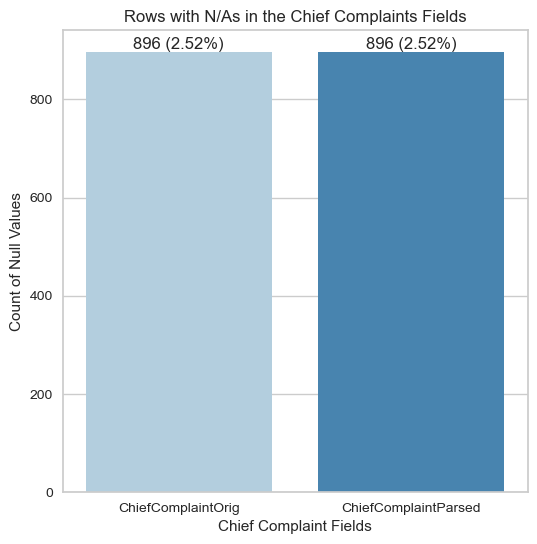

In [17]:
# Chief Complaint fields with null values
cc_orig = df.isnull().sum()[3]
cc_parsed = df.isnull().sum()[4]

# Calculate the percentage of null values
total_rows = len(df)
cc_orig_percentage = (cc_orig / total_rows) * 100
cc_parsed_percentage = (cc_parsed / total_rows) * 100

# plot the Chief Complaint fields
data = [cc_orig, cc_parsed]
labels = ['ChiefComplaintOrig', 'ChiefComplaintParsed']

# Create the bar plot
plt.figure(figsize=(6,6))
ax = sns.barplot(x=labels, y=data, palette="Blues")
plt.title('Rows with N/As in the Chief Complaints Fields')
plt.ylabel('Count of Null Values')
plt.xlabel('Chief Complaint Fields')

# Annotate the bars with percentage values
for i, v in enumerate(data):
    ax.text(i, v + 1, f'{v} ({data[i]/total_rows*100:.2f}%)', ha='center', va='bottom')

plt.show()

<blockquote>This plot shows the number and percentage of null values for each Chief Complaint field.</blockquote>

The rows with null values in these fields will not be kept further in the analysis, because these are the only 2 fields that contain information about Location, if any. If they are null then they don't provide any additional input to the models and so, those rows of data can be removed from the dataset.

In [18]:
# filtered_df1 = df[(df['ChiefComplaintOrig'].isnull()) & (df['ChiefComplaintParsed'].notna())]
# filtered_df1

In [19]:
# filtered_df2 = df[(df['ChiefComplaintParsed'].isnull()) & (df['ChiefComplaintOrig'].notna())]
# filtered_df2

In [20]:
# Drop rows where 'ChiefComplaintOrig' is null
# df = df.dropna(subset=['ChiefComplaintOrig'])

# Drop all rows where columns 'ChiefComplaintOrig' and 'ChiefComplaintParsed' are null
df = df.dropna()

#Check the shape now
df.shape

(34682, 6)

In [21]:
# Check for null values
df.isnull().sum()

Date                    0
Time                    0
Facility Name           0
ChiefComplaintOrig      0
ChiefComplaintParsed    0
Location                0
dtype: int64

In [22]:
# replace nulls with ''
# df = df.fillna("")

In [23]:
# find nulls
# df.isnull().sum()

#### Duplicate Values

In [24]:
# find duplicates
df.duplicated().sum()

10

In [25]:
# identify duplicate rows
df[df.duplicated()]

,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location
5846,2022-07-27,1970-01-01 00:50:00,NV-Valley Hospital Medical Center,Drug Overdose,DRUG OVERDOSE,0
18138,2020-06-09,1970-01-01 09:16:00,NV-Valley Hospital Medical Center,PT PICKED UP BY EMS FOUND DOWN ON THE STREET B...,PATIENT PICKED UP BY EMS FOUND DOWN ON STREET ...,0
31955,2017-10-11,1970-01-01 01:12:00,NV-Desert Springs Hospital Medical Center,OD,OVERDOSE,0
34840,2017-03-07,1970-01-01 10:57:00,NV-Summerlin Hospital Medical Center,seizures x 2; last one an hour ago; per EMS pt...,SEIZURES 2 LAST ONE AGO PER EMS PATIENT WAS UN...,0
34927,2017-02-27,1970-01-01 22:24:00,NV-St. Rose Dominican Hospitals - Rose De Lima...,TYLENOL OVERDOSE,TYLENOL OVERDOSE,0
35112,2017-02-11,1970-01-01 02:39:00,NV-Mesa View Regional Hospital,OVERDOSE,OVERDOSE,0
35211,2017-02-01,1970-01-01 20:42:00,NV-Sunrise Hospital & Medical Center,H OVERDOSE/S/P NARCAN,H OVERDOSE STATUS POST NARCAN,0
35241,2017-01-31,1970-01-01 02:03:00,NV-Desert Springs Hospital Medical Center,ETOH AMS Posible OD of unknown substance.,ALCOHOL ALTERED MENTAL STATUS POSIBLE OVERDOSE...,0
35432,2017-01-14,1970-01-01 13:22:00,NV-Spring Valley Hospital Medical Center,per EMS pt was at a friend's house taking a sh...,PER EMS PATIENT WAS AT A FRIEND S HOUSE TAKING...,0
35453,2017-01-12,1970-01-01 22:20:00,NV-Valley Hospital Medical Center,AMS ALCOHOL INTOXICATION UNSTEADY GAIT; PT PIC...,ALTERED MENTAL STATUS ALCOHOL INTOXICATION UNS...,0


In [26]:
# Drop duplicate rows while keeping the original one
df = df.drop_duplicates(keep='first')

# Check the dataset shape after removing duplicates
df.shape

(34672, 6)

+ We are going to save this dataset and it will be used for further exploratory data analysis (EDA). This will also be used a our final dataset to predict locations.

In [27]:
# Saving the cleaned dataset
df.to_csv('data/full_cleaned_data.csv', index=False)

The most number of hospital records for overdose patient admission in the data are from Valley Hospital Medical Center.

In [100]:
# Counts of records for each facility
df['Facility Name'].value_counts()

NV-Valley Hospital Medical Center                                          4281
NV-Sunrise Hospital & Medical Center                                       3719
NV-Spring Valley Hospital Medical Center                                   3070
NV-Renown Regional Er                                                      2980
NV-Desert Springs Hospital Medical Center                                  2352
NV-Henderson Hospital                                                      1814
NV-Summerlin Hospital Medical Center                                       1738
NV-Mountain View Hospital                                                  1734
NV-Centennial Hills Hospital Medical Center                                1680
NV-St. Mary's Regional Medical Center                                      1408
NV-UMCSN Hospital Emergency Department-ER                                  1390
NV-St. Rose Dominican Hospitals - Siena Campus                             1109
NV-North Vista Hospital                 

In [101]:
# plot the number of overdose cases by year
df['Year'] = pd.DatetimeIndex(df['Date']).year

Below is the number of cases by year.

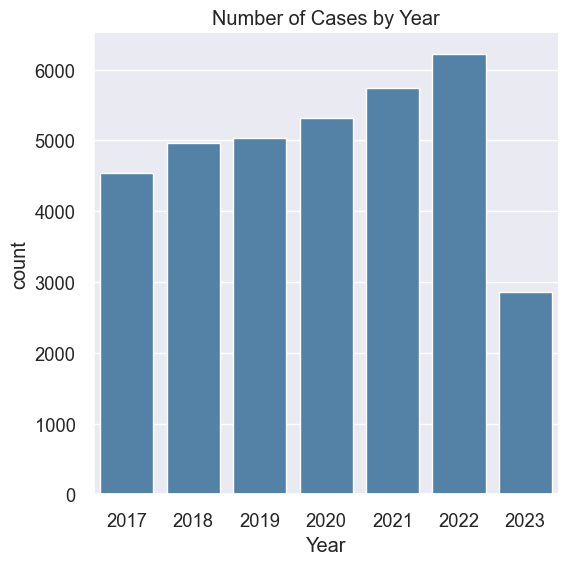

In [102]:
plt.figure(figsize=(6,6))
ax = sns.countplot(x='Year', data=df, color='steelblue').set(title='Number of Cases by Year')

<blockquote>The plot above shows the number of records for each year in the data. We can see continuous rise in number of cases in past 6 years. Year 2023 isn't complete yet and data is as of May.</blockquote>

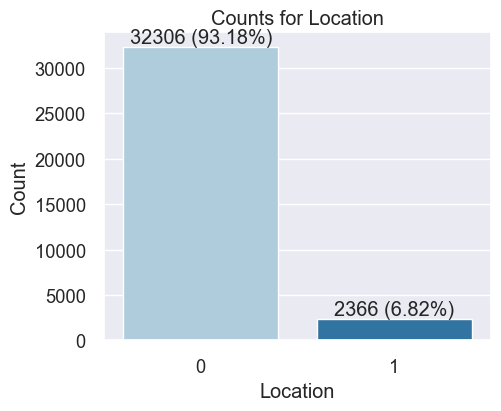

In [103]:
# Check the distribution for Location

total_count = len(df)
value_counts = df['Location'].value_counts()
percentages = (value_counts / total_count) * 100

sns.set_palette("Paired")
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Location', data=df, order=value_counts.index, saturation=0.75)
ax.set(xlabel='Location', ylabel='Count', title='Counts for Location')

# Annotate the bars with count and percentage values
for i, v in enumerate(value_counts):
    ax.text(i, v + 1, f'{v} ({percentages.iloc[i]:.2f}%)', ha='center', va='bottom')

plt.show()

<blockquote>The plot above shows the distribution for Location availability in the data. Only less than 7% of data has location present.</blockquote>

### Most Common Words in the Dataset

The top 10 words by frequency in 'ChiefComplaintsOrig' field are shown below. Stopwords like "the", "a", and "of" are not included. "pt" (i.e. patient) is the most frequent term, followed by "overdose", and "ems" (i.e. Emergency Medical Services). 

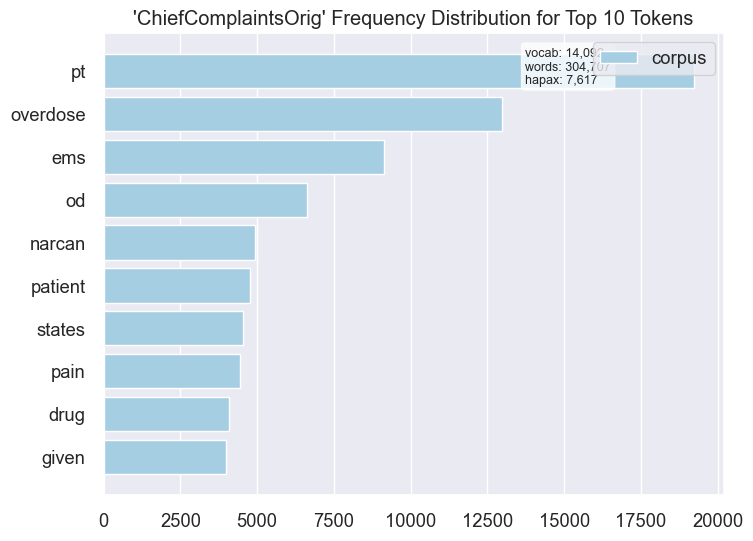

<AxesSubplot:title={'center':"'ChiefComplaintsOrig' Frequency Distribution for Top 10 Tokens"}>

In [104]:
#frequency distribution plot - ChiefComplaintOrig
corpus_cc_orig = df['ChiefComplaintOrig'].tolist()


vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(corpus_cc_orig)
features   = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h', n=10, size=(800, 600), title="'ChiefComplaintsOrig' Frequency Distribution for Top 10 Tokens")
visualizer.fit(docs)
visualizer.show()

The most frequent words in the 'ChiefComplaintParsed' field are almost identical to the 'ChiefComplaintOrig' field. As we can see below "pt" is expanded to "patient" in this field.

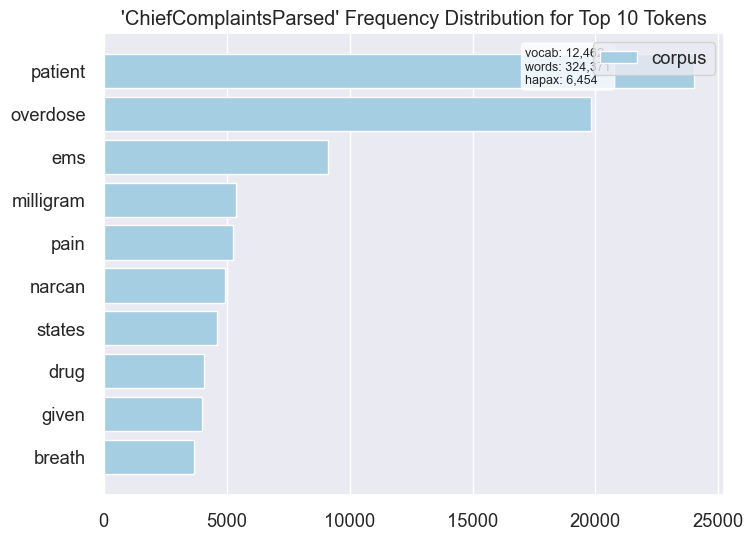

<AxesSubplot:title={'center':"'ChiefComplaintsParsed' Frequency Distribution for Top 10 Tokens"}>

In [105]:
#Frequency distributioin plot - ChiefComplaintParsed
corpus_cc_parsed = df['ChiefComplaintParsed'].tolist()


vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(corpus_cc_parsed)
features   = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h', n=10, size=(800, 600), title="'ChiefComplaintsParsed' Frequency Distribution for Top 10 Tokens")
visualizer.fit(docs)
visualizer.show()

Here is how the word cloud of the most common words in this dataset looks like.

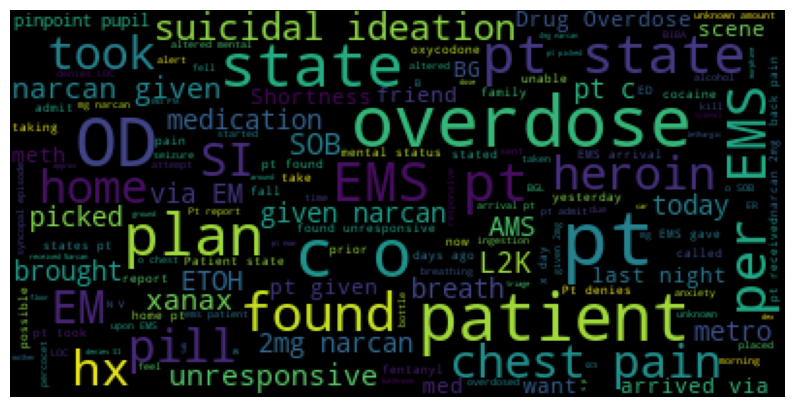

In [106]:
#get words
si=StringIO()
df['ChiefComplaintOrig'].apply(lambda x: si.write(str(x)))
s=si.getvalue()
si.close()
s[0:100]
text = s

#Generate a word cloud image
wordcloud = WordCloud().generate(text)

#take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_words=len(s),max_font_size=40, relative_scaling=.5).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud

<blockquote>It is not a surprise that word "overdose" is glaring at us, followed by "patient" and "EMS".</blockquote>

#### Import the Validation Dataset

In [28]:
# Import validation dataset
df_v = pd.read_excel('data/Validation_Dataset.xlsx')

In [29]:
df_v.shape

(6934, 8)

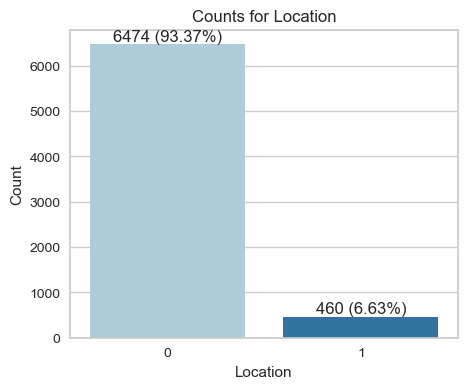

In [30]:
# Check the distribution for Location in validation dataset

total_count = len(df_v)
value_counts = df_v['Location'].value_counts()
percentages = (value_counts / total_count) * 100

sns.set_palette("Paired")
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Location', data=df_v, order=value_counts.index, saturation=0.75)
ax.set(xlabel='Location', ylabel='Count', title='Counts for Location')

# Annotate the bars with count and percentage values
for i, v in enumerate(value_counts):
    ax.text(i, v + 1, f'{v} ({percentages.iloc[i]:.2f}%)', ha='center', va='bottom')

plt.show()

In [ ]:
# plt.figure(figsize=(6,6))
# ax = sns.countplot(x='Year', data=df_v, color='steelblue').set(title='Number of Cases by Year')

#### Clean Dataset

In [31]:
# Change column names
df_v = df_v.rename(columns={'Label_Lat': 'label_lat', 'Label_Lon': 'label_lon'})
df_v['label_lat'] = df_v['label_lat'].astype(float)
df_v['label_lon'] = df_v['label_lon'].astype(float)

In [32]:
##### Add columns for index, logtitude and latitude in validation dataset
# df_v = df_v.assign(Index = 0, label_lat = np.nan, label_lon = np.nan)

# df_v['label_lat'] = df_v['label_lat'].astype(float)
# df_v['label_lon'] = df_v['label_lon'].astype(float)

# Handling data format for logtitude and latitude
# df_v['label_lat'] = df_v['label_lat'].round(decimals = 4)
# df_v['label_lon'] = df_v['label_lon'].round(decimals = 4)

# Add column for index
df_v = df_v.assign(Index = 0)
# df_v['Index'] = df_v['Index'].fillna(0)
# df_v['Index'] = df_v['Index'].astype(int)

# Handling data format for logtitude and latitude
df_v['label_lat'] = df_v['label_lat'].round(decimals = 4)
df_v['label_lon'] = df_v['label_lon'].round(decimals = 4)

In [33]:
# Add columns for count of words in ChiefComplaintOrig and ChiefComplaintParsed fields
df_v['len_cco'] = df_v['ChiefComplaintOrig'].str.len()
df_v['len_ccp'] = df_v['ChiefComplaintParsed'].str.len()

In [34]:
# Rearranging columns in validation dataframe
df_v = df_v[['Index', 'Date', 'Time', 'Facility Name', 'ChiefComplaintOrig',
       'ChiefComplaintParsed', 'Location', 'label_lat',
       'label_lon', 'len_cco', 'len_ccp']]

In [35]:
df_v.head(3)

,Index,Date,Time,Facility Name,ChiefComplaintOrig,ChiefComplaintParsed,Location,label_lat,label_lon,len_cco,len_ccp
0,0,2023-05-28,1970-01-01 05:03:00,NV-Mountain View Hospital,TOXIC METABOLIC ENCEPHOLP NARCOTIC OD,TOXIC METABOLIC ENCEPHOLP NARCOTIC OVERDOSE,0,NaN,NaN,37,43
1,0,2023-05-28,1970-01-01 04:21:00,NV-UMCSN Hospital Emergency Department-ER,OVERDOSE,OVERDOSE,0,NaN,NaN,8,8
2,0,2023-05-27,1970-01-01 21:35:00,NV-Spring Valley Hospital Medical Center,C/o Suicidal Ideation. Patient states he attem...,COMPLAINS OF SUICIDAL IDEATION PATIENT STATES ...,0,NaN,NaN,139,141


In [36]:
# Copy validation data into new dataframes for each model
df_sp = df_v.copy()
df_crf = df_v.copy() 
df_gzt = df_v.copy()
df_ktr = df_v.copy()
df_sp_ccp = df_v.copy()
df_crf_ccp = df_v.copy()
df_gzt_ccp = df_v.copy()
df_ktr_ccp = df_v.copy()

In [107]:
# New dataframe with the count of characters for Chief Complaint fields
len_df = pd.melt(df_v, id_vars=['Location'], value_vars=['len_cco', 'len_ccp'])

<AxesSubplot:xlabel='variable', ylabel='value'>

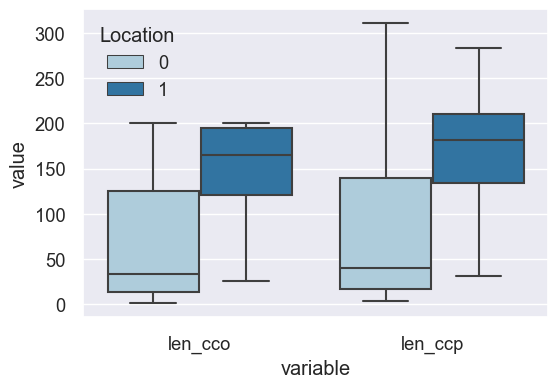

In [108]:
# Boxplots for label and character counts
plt.figure(figsize=(6,4))
sns.boxplot(x='variable', y='value', hue='Location', data=len_df)

## Model Building and Evaluations

Running the NER models and getting the geographical coordinates from Google.

#### Common Functions

In [37]:
# Load the en_core_web_sm spacy model
nlp = spacy.load("en_core_web_sm")

In [38]:
# Create a stopwords list of terms to exclude
exclude_list = ['Metro Police','Metro police','Metro','metro','MEtro','PD','AMS','EMS','ems','BIBA','Biba','biba','ED','ed','ABX','abx','L2K','L2 K','L2k','l2k','BG','bg','BGL','bgl','CIA','FBI','fbi','ER','er','SI','si','ABCD','EMT','ETOH','etoh','TRFR','trfr','TRF','trf','GUN','Gun','LLE','lle','LVMPD','ASSAULTED','ASSAULT','Assault','KNIFE','PTA','STD','ABD']

spaCy - Get Location Named Entities

In [39]:
# Takes in a string and a type of location (GPE, LOC, FAC, ORG), runs NER, returns a string of the named entity 
def get_spacy_ner(text, type):
    """Returns a Named Entity string"""
    doc = nlp(text)
    org_list = [(X.text) for X in doc.ents if X.label_ in type and X.text not in exclude_list]
    string = ', '.join(str(e) for e in org_list)
    return string

Custom NER with CRF - Get Locations

In [40]:
# Takes in a string and returns a list of geos
def get_geos(text):
    """Returns a list of -geo tags"""
    text = re.sub(r'\n', '', text)
    text_tokens = nltk.word_tokenize(text)
    text_pos = nltk.pos_tag(text_tokens)
    
    #extract features from POS tagged text document
    features = [sent2features(text_pos)]
    
    #use trained model to predict features engineered
    labels = crf.predict(features)
    doc_labels = labels[0]

    text_ner = [(token, tag) for token, tag in zip(text_tokens, doc_labels)]
    
    named_entities = []
    temp_entity_name = ''
    temp_named_entity = None
    
    for term, tag in text_ner:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
                
    #iterate through the named entities and extract the geo entities         
    geo_list = []
    for x in named_entities:
        if 'geo' in x[1] and x[0] not in exclude_list: 
            geo_list.append(x[0])
        elif 'org' in x[1] and x[0] not in exclude_list and not x[0].isupper(): 
            geo_list.append(x[0])
        elif 'gpe' in x[1] and x[0] not in exclude_list: 
            geo_list.append(x[0])
        else:
            geo_list.append('')
    return(geo_list)

Get Coordinates from Google Maps API

In [41]:
# Takes the NER location text field and passes it to the Google Maps API
def get_coords(text):
    coords = (np.nan, np.nan)
    try:
        address = text + " Las Vegas, NV"

        #build the endpoint URL
        target_url = ('https://maps.googleapis.com/maps/api/geocode/json?''address={0}&key={1}').format(address, gkey)
        
#         print(target_url)

        #send request to endpoint and convert result to json
        geo_data = requests.get(target_url).json()
        
        #extract the lat and lng
        lat = geo_data["results"][0]["geometry"]["location"]["lat"]
        lng = geo_data["results"][0]["geometry"]["location"]["lng"]
        loc_type = geo_data["results"][0]["geometry"]["location_type"]
        long_name = geo_data["results"][0]["address_components"][0]["long_name"]
        if loc_type == 'APPROXIMATE' and long_name == 'Las Vegas':
            coords = (np.nan, np.nan)
        else:
            coords = (lat, lng)
        print(coords, loc_type, long_name)
        print("---------------")

    except:
        coords = (np.nan, np.nan)
    return coords

Call Google with the spaCy NERs

In [42]:
# Takes a df input and passes the NER location to the get_coords function (calling Google)
# Sets the lat/lon column if found
def call_google_api(df):
    start = timer()
    coords = []
    for i, row in df.iterrows():
        if df['Streets'].iloc[i] != "":
            coords = get_coords(df['Streets'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['FACs'].iloc[i] != "":
            coords = get_coords(df['FACs'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['LOCs'].iloc[i] != "":
            coords = get_coords(df['LOCs'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['GPEs'].iloc[i] != "":
            coords = get_coords(df['GPEs'].iloc[i] )
            df_sp.at[i,'lat'] = coords[0]
            df_sp.at[i,'lon'] = coords[1]
        elif df['Orgs'].iloc[i] != "":
            coords = get_coords(df['Orgs'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        else:
            coords = (np.nan, np.nan)
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
    end = timer()
    print(timedelta(seconds=end-start))

Call Google with the Custom NER

In [43]:
# Takes a df input and passes the NER location to the get_coords function (calling Google)
# Sets the lat/lon column if found
def call_google_api_custom(df):
    start = timer()
    coords = []
    for i, row in df.iterrows():
        if df['Loc1'].iloc[i] != "":
            coords = get_coords(df['Loc1'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        else:
            coords = (np.nan, np.nan)
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
    end = timer()
    print(timedelta(seconds=end-start))

Call Google with the Ktrain NER

In [44]:
# Takes a df input and passes the NER location to the get_coords function (calling Google)
# Sets the lat/lon column if found
def call_google_api_ktrain(df):
    coords = []
    for i, row in df.iterrows():
        if df['Loc4'].iloc[i] != "":
            coords = get_coords(df['Loc4'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['Loc1'].iloc[i] != "":
            coords = get_coords(df['Loc1'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['Loc3'].iloc[i] != "":
            coords = get_coords(df['Loc3'].iloc[i] )
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        elif df['Loc2'].iloc[i] != "":
            coords = get_coords(df['Loc2'].iloc[i])
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]
        else:
            coords = (np.nan, np.nan)
            df.at[i,'lat'] = coords[0]
            df.at[i,'lon'] = coords[1]

Get Prediction of 0/1

In [45]:
# Sets 0/1 labels. If there is a lat/lon present, then label = 1. If not present, then label = 0.
def get_prediction(df):
    for i, row in df.iterrows():
        if np.isnan(row['lat']) and np.isnan(row['lon']):
            df.at[i,'pred'] = 0
        else:
            df.at[i,'pred'] = 1

Evaluate Predictions

In [46]:
# Compares the lat/lon found in Google Maps to the label_lat/label_lon provided in the training data
# Sets a value for each row for True Negative (TN), True Positive (TP), False Negative (FN), False Positive (FP)
def pred_eval(df):
    for i, row in df.iterrows():
        lat = df['lat'].iloc[i]
        lon = df['lon'].iloc[i]
        lab_lat = df['label_lat'].iloc[i]
        lab_lon = df['label_lon'].iloc[i]
        lat_null = np.isnan(lat)
        lon_null = np.isnan(lon)
        lab_lat_null = np.isnan(lab_lat)
        lab_lon_null = np.isnan(lab_lon)
        label = df['pred'].iloc[i]

        #TN
        if lat_null and lon_null and lab_lat_null and lab_lon_null and label == 0:
            df.at[i,'pred_eval'] = 'TN'

        #TP
        elif not lat_null and not lon_null and not lab_lat_null and not lab_lon_null and label == 1:
            loc1 = (lab_lat, lab_lon)
            loc2 = (lat, lon)
            dist = distance.distance(loc1, loc2).miles
            if dist <= 1:
                df.at[i,'pred_eval'] = 'TP'
            else: 
                df.at[i,'pred_eval'] = 'FP'

        #FN
        elif lat_null and lon_null and not lab_lat_null and not lab_lon_null and label == 0:
            df.at[i,'pred_eval'] = 'FN'

        #FP
        elif not lat_null and not lon_null and lab_lat_null and lab_lon_null and label == 1:
            df.at[i,'pred_eval'] = 'FP'

        else:
            print('unknown')

Evaluation Metrics

In [47]:
# Uses the TP, TN, FP, FN values to returns Accuracy, Precision, Recall, and F1 scores
# Takes in a df, the model name, and the df column used in the NER
def get_scores(df, model, col):
    preds = df['pred_eval'].value_counts()
    tp = preds.loc['TP']
    tn = preds.loc['TN']
    fp = preds.loc['FP']
    fn = preds.loc['FN']
    acc = round((tp + tn)/(tp + tn + fp + fn),4)
    prec = round(tp / (tp + fp),4)
    rec = round(tp / (tp + fn), 4) 
    f1 = round(2 * (prec * rec) / (prec + rec), 4)
    return [[model, col, acc, prec, rec, f1]]

---------------------------------------

### spaCy NER

This code identifies NER locations using a basic spaCy model. The model is run once for the 'ChiefComplaintOrig' field and once for the 'ChiefComplaintParsed' field.

In [109]:
# Takes in a dataframe and column name and calls the get_spacy_ner function
def run_spacy(df, col):
    start = timer()
    print(col)
    streets = []
    orgs = []
    geo_entities = []
    facs = []
    locs = []

    #loops through the df column passed in and calls the get_spacy_ner function for each spaCy location type (ORG, GPE, FAC, LOC)
    #Adds results to lists
    for i in range(len(df)):
        complaint = df[col].iloc[i].replace("OD", "Overdose").replace("pt", "patient").replace("GSW", "gun shot wound").replace("Metro", "Metro Police").replace("LOC", "loss of control")
        temp_streets = get_spacy_ner(complaint, 'STREET')
        streets.append(temp_streets)
        temp_orgs = get_spacy_ner(complaint, 'ORG')
        orgs.append(temp_orgs)
        temp_geos = get_spacy_ner(complaint, 'GPE')
        geo_entities.append(temp_geos)
        temp_facs = get_spacy_ner(complaint, 'FAC')
        facs.append(temp_facs)
        temp_locs = get_spacy_ner(complaint, 'LOC')
        locs.append(temp_locs)

    #saves the ners back to the df
    df['Streets'] = streets
    df['FACs'] = facs
    df['Orgs'] = orgs
    df['GPEs'] = geo_entities
    df['LOCs'] = locs
    
    end = timer()
    print(timedelta(seconds=end-start))

#### ChiefComplaintOrig

In [110]:
# Pass dataframe and the column name to the run_spacy_ner function
run_spacy(df_sp,'ChiefComplaintOrig')

ChiefComplaintOrig
0:03:02.480305


In [111]:
df_sp.shape

(6934, 16)

In [112]:
print('Number of FACs: ', len(df_sp['FACs'].unique()))
print('Number of Orgs: ', len(df_sp['Orgs'].unique()))
print('Number of GPEs: ',len(df_sp['GPEs'].unique()))
print('Number of LOCs: ', len(df_sp['LOCs'].unique()))

Number of FACs:  62
Number of Orgs:  1300
Number of GPEs:  218
Number of LOCs:  35


In [113]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api(df_sp)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_sp)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_sp)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(31.9685988, -99.9018131) APPROXIMATE Texas
---------------
(36.110132, -115.175128) ROOFTOP 3700
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, na

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1860991, -115.1348596) ROOFTOP 314
---------------
(36.1610061, -115.1527427) GEOMETRIC_CENTER South Main Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE L

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0574196, -115.2720575) ROOFTOP 8280
---------------
(36.1590854, -115.2058635) APPROXIMATE Charleston
---------------
(36.1951676, -115.0205566) ROOFTOP 6901
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.262445, -115.2667538) GEOMETRIC_CENTER Desert Spring Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1690405, -115.1398293) ROOFTOP 518
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
---------------
(36.1611352, -115.1514715) ROOFTOP 917
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.213472, -115.248659) ROOFTOP 2880
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1161575, -115.131061) ROOFTOP 1640
---------

(36.1452546, -115.1691203) ROOFTOP 2412
---------------
(36.0876717, -115.1722566) ROOFTOP 4605
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2282467, -115.3058698) GEOMETRIC_CENTER Cheyenne Ridge Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1714041, -115.1784423) GEOMETRIC_CENTER Desert View Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1707764, -115.1396012) ROOFTOP 200-220
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1013982, -115.1851788) ROOFTOP 3330
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIM

(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1707954, -115.1432647) ROOFTOP 200
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.1677662, -115.2860419) ROOFTOP Suite 150
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.1872435, -115.1357861) ROOFTOP 1502
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(36.1872435, -115.1357861) ROOFTOP 1502
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0673501, -115.1281419) ROOFTOP 6747
---------------
(36.1355411, -115.1373436) ROOFTOP 110
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1951227, -115.2495388) ROOFTOP Ste 280
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1105465, -115.1460237) ROOFTOP Lied Athletic Complex
------------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0422594, -115.0072327) GEOMETRIC_CENTER South Fourth Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1281179, -115.1733763) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.114436, -115.1948157) ROOFTOP 4321
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
---------------
(nan, nan) APPROXIMATE 

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(31.9685988, -99.9018131) APPROXIMATE Texas
---------------
(36.1456186, -115.1725657) ROOFTOP 2400
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1938785, -115.2070972) ROOFTOP 1925
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1699671, -115.1448235) ROOFTOP 129
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vega

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1196339, -115.1790057) GEOMETRIC_CENTER Stan Mallin Drive
---------------
(36.113434, -115.121928) ROOFTOP 2235
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1737167, -115.0647622) ROOFTOP 5001
---------------
(36.0921847, -115.1748583) ROOFTOP 3950
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0395247, -114.9817213) APPROXIMATE Henderson
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.243184, -115.253059) GEOMETRIC_CENTER Vogue Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1582902, -115.3398671) GEOMETRIC_CENTER Kindred Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2120112, -115.2345772) ROOFTOP 6409
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0987973, -115.1754312) ROOFTOP 3850
---------------
(36.1370097, -115.2890343) APPROXIMATE The Lakes
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1643201, -115.1292172) GEOMETRIC_CENTER East Fremont Street & South 15th Street
-----

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(36.1557995, -115.1944763) ROOFTOP 1330
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(35.9782216, -114.8345117) APPROXIMATE Boulder City
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1105465, -115.1460237) ROOFTOP Lied Athletic Complex
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0988118, -115.1703887) ROOFTOP 3801
---------------
(nan, nan) APPROXIMATE Las Vegas
-----------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0735337, -115.2488371) ROOFTOP 7201
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.18135, -115.1598857) GEOMETRIC_CENTER N Street
---------------
(nan, nan) APPROXIMATE Las Vegas

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.158549, -115.320658) ROOFTOP 10401
---------------
(36.0921847, -115.1748583) ROOFTOP 3950
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1105155, -115.2004776) ROOFTOP 4499
---------------
(36.158602, -115.185833) ROOFTOP # 202
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2418514, -115.0658709) GEOMETRIC_CENTER Lowry Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1550762, -115.1379325) GEOMETRIC_CENTER South 11th Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1345244, -115.1375219) ROOFTOP 202
---------------
(36.135635, -115.2304131) GEOMETRIC_CENTER Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1043814, -115.1184778) ROOFTOP 4660
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPR

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1737167, -115.0647622) ROOFTOP 5001
---------------
(36.2192734, -115.2431513) ROOFTOP Cheyenne Village
---------------
(36.1596802, -115.2301768) ROOFTOP 6250
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1423552, -115.1567235) ROOFTOP 2535
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2492358, -115.2091443) GEOMETRIC_CENTER Needles Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2418514, -115.0658709) GEOMETRIC_CENTER Lowry Circle
---------------
(36.1334097, -115.1371758) ROOFTOP 3101
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.102132, -115.1744225) ROOFTOP 3790
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1105465, -115.1460237) ROOFTOP Lied Athletic Complex
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
--------------

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0960302, -115.1927328) ROOFTOP C
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1042089, -115.1723159) ROOFTOP #120
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1150926, -115.2055581) ROOFTOP D
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, 

In [114]:
# Export results to csv
df_sp.to_csv('temp/spacy_cco.csv')

#### Results

In [115]:
# Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_sp = get_scores(df_sp, 'spaCy', 'ChiefComplaintOrig')

# Save results to a df
results_sp_df = pd.DataFrame(results_sp, columns = ['Model', 'Field','Accuracy', 'Precision', 'Recall', 'F1'])
results_sp_df

,Model,Field,Accuracy,Precision,Recall,F1
0,spaCy,ChiefComplaintOrig,0.8556,0.1302,0.3305,0.1868


#### ChiefComplaintParsed

In [116]:
# Pass dataframe and the column name to the run_spacy_ner function
run_spacy(df_sp_ccp,'ChiefComplaintParsed')

ChiefComplaintParsed
0:03:01.416381


In [117]:
df_sp_ccp.shape

(6934, 16)

In [118]:
print('Number of FACs: ', len(df_sp_ccp['FACs'].unique()))
print('Number of Orgs: ', len(df_sp_ccp['Orgs'].unique()))
print('Number of GPEs: ',len(df_sp_ccp['GPEs'].unique()))
print('Number of LOCs: ', len(df_sp_ccp['LOCs'].unique()))

Number of FACs:  28
Number of Orgs:  1776
Number of GPEs:  99
Number of LOCs:  5


In [119]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api(df_sp_ccp)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_sp_ccp)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_sp_ccp)

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1584689, -115.3145019) ROOFTOP 1115
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) AP

(36.0631715, -115.2206273) GEOMETRIC_CENTER Badura Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.18135, -115.1598857) GEOMETRIC_CENTER N Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPRO

(36.1449176, -115.1736541) ROOFTOP Suite 800
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, na

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.158602, -115.185833) ROOFTOP # 202
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1657803, -115.2457416) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(n

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(nan, nan) AP

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1961019, -115.2483205) GEOMETRIC_CENTER West Lake Mead Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1238664, -115.1688631) ROOFTO

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1699671, -115.1448235) ROOFTOP 129
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0574086, -115.1564187) ROOFTOP 340
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1136197, -115.1718645) GEOMETRIC_CENTER Ballys Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas


(36.1678236, -115.1620172) APPROXIMATE Las Vegas Metropolitan Police Department
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1727526, -115.1411887) ROOFTOP Las Vegas
---------------
(36.1141275, -115.1965118) ROOFTOP 4321
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(na

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1893332, -115.157255) GEOMETRIC_CENTER North K Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
-----------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1714041, -115.1784423) GEOMETRIC_CENTER Desert View Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2192734, -115.2431513) ROOFTOP Cheyenne Village
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(36.102132, -115.1744225) ROOFTOP 3790
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APP

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1263033, -115.2463049) ROOFTOP 7000
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1281179, -115.1733763) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.187671, -115.2776486) GEOMETRIC_CENTER Couples Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE La

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1279211, -115.1505898) GEOMETRIC_CENTER South Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.10405, -115.1703445) GEOMETRIC_CENTER MGM Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las V

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.168491, -115.3147778) ROOFTOP Suite 120
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.125289, -115.219993) ROOFTOP # 4
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan,

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(36.1281179, -115.1733763) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
--------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2192734, -115.2431513) ROOFTOP Cheyenne Village
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(

(36.0921847, -115.1748583) ROOFTOP 3950
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.158602, -115.185833) ROOFTOP # 202
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.042

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0081705, -114.9653903) ROOFTOP 700
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1471544, -115.1369351) GEOMETRIC_CENTER South Maryland Parkway
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Ve

(36.176089, -115.131719) ROOFTOP 701-705
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2366064, -115.0547049) ROOFTOP Park
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1489272, -115.1528455) ROOFTOP 1901
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
--------------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.113434, -115.121928) ROOFTOP 2235
---------------
(36.2797414, -115.2801469) ROOFTOP Unit 100 Suite 100
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(36.1596802, -115.2301768) ROOFTOP 6

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.065187, -115.120291) ROOFTOP UNIT 103
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1129455, -115.1765067) ROOFTOP 3600
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1522617, -115.2064901) ROOFTOP Ste 4A
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2986311, -115.2182764) GEOMETRIC_CENTER Royal Springs Avenue
---------------
(nan, nan) A

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1729812, -115.1448364) ROOFTOP 12
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, na

In [120]:
# Export results to csv
df_sp_ccp.to_csv('temp/spacy_cco_ccp.csv')

#### Results

In [121]:
#pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_sp_ccp = get_scores(df_sp_ccp, 'spaCy', 'ChiefComplaintParsed')

#save results to a df
results_sp_df_ccp = pd.DataFrame(results_sp_ccp, columns = ['Model', 'Field','Accuracy', 'Precision', 'Recall', 'F1'])
results_sp_df_ccp

,Model,Field,Accuracy,Precision,Recall,F1
0,spaCy,ChiefComplaintParsed,0.9027,0.1514,0.1422,0.1467


-------------------

### Spacy NER with a Las Vegas Street Name Gazetteer
This code identifies NER locations using a basic spaCy model with a Las Vegas street name gazetteer.

#### ChiefComplaintOrig
Creating a dictionary from a street index for Las Vegas.

In [122]:
# Import list of streets in Las Vegas
cc_streets = pd.read_csv('data/street_names2.csv')

# Drop unneeded column
cc_streets = cc_streets.drop(columns=['FID'])

# Create a list of streets
street_list = cc_streets["STRNAME"].tolist()
street_list = sorted(list(set(street_list)))

In [123]:
# Take a list and a label and append it
def create_training_data(list, type):
    patterns = []
    for item in list:
        pattern = {
            "label":type,
            "pattern":item
            }
        patterns.append(pattern)
    return(patterns)

In [124]:
# Create training data that includes streets
dict = create_training_data(street_list, "STREET")
dict

[{'label': 'STREET', 'pattern': '10th'},
 {'label': 'STREET', 'pattern': '11'},
 {'label': 'STREET', 'pattern': '11th'},
 {'label': 'STREET', 'pattern': '12th'},
 {'label': 'STREET', 'pattern': '13th'},
 {'label': 'STREET', 'pattern': '147'},
 {'label': 'STREET', 'pattern': '14th'},
 {'label': 'STREET', 'pattern': '15'},
 {'label': 'STREET', 'pattern': '159'},
 {'label': 'STREET', 'pattern': '15th'},
 {'label': 'STREET', 'pattern': '160'},
 {'label': 'STREET', 'pattern': '161'},
 {'label': 'STREET', 'pattern': '163'},
 {'label': 'STREET', 'pattern': '164'},
 {'label': 'STREET', 'pattern': '165'},
 {'label': 'STREET', 'pattern': '168'},
 {'label': 'STREET', 'pattern': '169'},
 {'label': 'STREET', 'pattern': '16th'},
 {'label': 'STREET', 'pattern': '170'},
 {'label': 'STREET', 'pattern': '172'},
 {'label': 'STREET', 'pattern': '17th'},
 {'label': 'STREET', 'pattern': '18th'},
 {'label': 'STREET', 'pattern': '19th'},
 {'label': 'STREET', 'pattern': '1st'},
 {'label': 'STREET', 'pattern': 

In [125]:
# Add streets to the pipeline
ruler = nlp.add_pipe("entity_ruler","ruleActions", config={"overwrite_ents": True})
patterns = dict
ruler.add_patterns(patterns)

Extract street names and add to dataframe

In [126]:
# Pass dataframe and the column name to the run_spacy_ner function
run_spacy(df_gzt,'ChiefComplaintOrig')

ChiefComplaintOrig
0:03:24.119279


In [127]:
df_gzt.shape

(6934, 16)

In [128]:
print('Number of Streets: ', len(df_gzt['Streets'].unique()))
print('Number of FACs: ', len(df_gzt['FACs'].unique()))
print('Number of Orgs: ', len(df_gzt['Orgs'].unique()))
print('Number of GPEs: ',len(df_gzt['GPEs'].unique()))
print('Number of LOCs: ', len(df_gzt['LOCs'].unique()))

Number of Streets:  292
Number of FACs:  32
Number of Orgs:  1192
Number of GPEs:  168
Number of LOCs:  14


In [129]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api(df_gzt)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_gzt)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_gzt)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(31.9685988, -99.9018131) APPROXIMATE Texas
---------------
(36.110132, -115.175128) ROOFTOP 3700
---------------
(nan, na

(36.112462, -115.1707075) ROOFTOP 3655
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0662301, -115.0549131) ROOFTOP 701
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(36.057369, -115.243544) ROOFTOP 7235
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.1175148, -115.1881593) ROOFTOP 3700
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2093033, -115.1076011) GEOMETRIC_CENTER Las Vegas Boulevard North
---------------
(36.1652493, -115.1620823) GEOMETRIC_CENTER Desert Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1860991, -115.1348596) ROOFTOP 3

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.126119, -115.1619583) ROOFTOP 3131
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1281179, -115.1733763) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1199703, -115.1137149) GEOMETRIC_CENTER Topaz
---------------
(35.9621569, -115.0832572) GEOMETRIC_CENTER Golf Crest Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.3036226, -115.2985478) GEOMETRIC_CENTER 11
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2117627, -115.1286006) GEOMETRIC_CENT

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1076743, -115.1383108) ROOFTOP 4505
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1518047, -115.2080597) GEOMETRIC_CENTER South Decatur Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1737167, -115.0647622) ROOFTOP 5001
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0100527, -115.163495) GEOMETRIC_CENTER Gilespie Street
---------------
(36.204895, -115.247272) ROOFTOP 713

(36.3036226, -115.2985478) GEOMETRIC_CENTER 11
---------------
(36.3036226, -115.2985478) GEOMETRIC_CENTER 11
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2076616, -115.0304215) GEOMETRIC_CENTER Mercy Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1773314, -115.1924299) GEOMETRIC_CENTER North Valley View Boulevard & West Bonanza Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2309398, -115.2233699) ROOFTOP 3968
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1542742, -115.0752403) GEOMETRIC_CENTER South Lucky Street
---------------
(36.1329379, -115.084697) ROOFTOP 4111
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1846745, -115.1055478) GEOMETRIC_CENTER Aztec Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1167166, -115.1863594) ROOFTOP 3700
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.07645249999999, -115.2986501) ROOFTOP 6125
---------------
(35.9677272, -114.8431754) ROOFTOP 901
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE L

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1707764, -115.1396012) ROOFTOP 200-220
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2117627, -115.1286006) GEOMETRIC_CENTER U.S. 93
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1737167, -115.0647622) ROOFTOP 5001
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1720189, -115.1298202) GEOMETRIC_CENTER North Maryland Parkway
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.153639, -115.20337) GEOMETRIC_CENTER Metropolitan Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.102132, -115.1744225) ROOFTOP 3790
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(36.

(36.1147065, -115.1728484) APPROXIMATE Las Vegas Strip
---------------
(36.1714041, -115.1784423) GEOMETRIC_CENTER Desert View Street
---------------
(36.1428804, -115.1070073) ROOFTOP 3139
---------------
(36.1615632, -115.303843) GEOMETRIC_CENTER Palace Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1833612, -115.3099185) ROOFTOP 1200
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1076743, -115.1383108) ROOFTOP 4505
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1729812, -115.1448364) ROOFTOP 12
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1942536, -115.3052885) ROOFTOP Suite 3-582
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.102132, -115.1744225) ROOFTOP 3790
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1741523, -115.1313588) GEOM

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0930789, -115.177319) ROOFTOP 3940
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1652493, -115.1620823) GEOMETRIC_CENTER Desert Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1194645, -115.1716391) ROOFTOP 3475
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2141116, -115.3424046) GEOMETRIC_CENTER Desert Hope Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1234185, -115.2171112) ROOFTOP 3651
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.166475, -115.2645258) GEOMETRIC_CEN

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1729812, -115.1448364) ROOFTOP 12
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(36.2322001, -115.2510207) ROOFTOP # 110
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1824893, -115.1539933) GEOMETRIC_CENTER I Street
---------------
(36.2090256, -115.2137825) ROOFTOP 2709
---------------
(36.2076973, -115.0309541) GEOMETRIC_CENTER Friends
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0286828, -115.2233699) ROOFTOP 8925
---------------
(nan, nan) APPROXIMATE Las Vegas
------------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2156347, -115.2989005) GEOMETRIC_CENTER January Drive
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2704261, -115.2104062) APPROXIMATE The Springs
---------------
(36.1599478, -115.2793149) ROOFTOP 85

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.126119, -115.1619583) ROOFTOP 3131
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.228758, -115.3047712) ROOFTOP 9632
---------------
(36.1925876, -115.3063795) ROOFTOP 5
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.07645249999999, -115.2986501) ROOFTOP 6125
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1670165, -115.2855227) ROOFTOP suite 180
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1428804, -115.1070073) ROOFTOP 3139
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0574086, -115.1564187) ROOFTOP 340
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APP

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1105155, -115.2004776) ROOFTOP 4499
---------------
(36.158602, -115.185833) ROOFTOP # 202
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.08389380000001, -115.1537166) ROOFTOP 5757
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1550762, -115.1379325) GEOMETRIC_CENTER South 11th Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(36.0673501, -115.1281419) ROOFTOP 6747
---------------
(36.1652493, -115.1620823) GEOMETRIC_CENTER Desert Lane
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(36.1828361, -115.1507758) GEOMETRIC_CENTER G Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2251083, -115.0986225) GEOMETRIC_CENTER North Pecos Road & East Gowan Road
-

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(36.1281179, -115.1733763) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1345244, -115.1375219) ROOFTOP 202
---------------
(36.135635, -115.2304131) GEOMETRIC_CENTER Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1043814, -115.1184778) ROOFTOP 4660
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
--------------

(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(36.1475119, -115.1565537) ROOFTOP 2000
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0569064, -115.2893859) GEOMETRIC_CENTER Falls
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0831046, -115.1482023) ROOFTOP Harry Reid International Airport
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.102181, -115.250659) GEOMETRIC_CENTER Homewood Drive
---------------
(36.2192734, -115.2431513) ROOFTOP Cheyenne Village
---------------
(36.1596802, -115.2301768) ROOFTOP 6250
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1438058, -115.1466411

(nan, nan) APPROXIMATE Las Vegas
---------------
(35.9840501, -115.1467728) GEOMETRIC_CENTER Nevada 146
---------------
(36.1079197, -115.0564212) ROOFTOP 5255
---------------
(36.2145028, -116.0250381) ROOFTOP 360
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.122765, -115.1453182) ROOFTOP 860
---------------
(36.122765, -115.1453182) ROOFTOP 860
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1729812, -115.1448364) ROOFTOP 12
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2492358, -115.2091443) GEOMETRIC_CENTER Needles Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2751033, -115.2800857) ROOFTOP 6166
---------------
(nan, nan) APPROXIMATE Las Vegas
---

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1585988, -115.2026957) ROOFTOP 4575
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1884891, -115.1608232) APPROXIMATE West Las Vegas
---------------
(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(36.1791123, -115.0875744) GEOMETRIC_CENTER Emerald Way
---------------
(36.1443722, -115.1998104) GEOMETRIC_CENTER Arville Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.057369, -115.243544) ROOFTOP 7235
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1707954, -115.1432647) ROOFTOP 200
---------------
(36.1155988, -115.199327) GEOMETRIC_CENTER Arville Street & West Flamingo Road
---------------


(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1307191, -115.192575) ROOFTOP U
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1517674, -115.1152877) GEOMETRIC_CENTER Pacific Street
---------------
(36.2054023, -115.2569943) ROOFTOP Suite 110
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1729812, -115.1448364) ROOFTOP 12
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------


In [130]:
# Export results to csv
df_gzt.to_csv('temp/spacy_gzt_cco.csv')

#### Results

In [131]:
# Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_gzt = get_scores(df_gzt, 'spaCy w/ Gazetteer', 'ChiefComplaintOrig')

# Save results to a df
results_gzt_df = pd.DataFrame(results_gzt, columns = ['Model', 'Field','Accuracy', 'Precision', 'Recall', 'F1'])
results_gzt_df

,Model,Field,Accuracy,Precision,Recall,F1
0,spaCy w/ Gazetteer,ChiefComplaintOrig,0.8543,0.1267,0.3285,0.1829


#### ChiefComplaintParsed

In [132]:
# Make a copy of the streets
cc_streets_ccp = cc_streets.copy()

# Convert streets to upper case for the 'ChiefComplaintParsed' field
cc_streets_ccp = cc_streets_ccp['STRNAME'].str.upper()

In [133]:
# Create a list of streets
street_list_ccp = cc_streets_ccp.tolist()
street_list_ccp = sorted(list(set(street_list_ccp)))

In [134]:
# Create training data that includes streets in capital letters
dict_ccp = create_training_data(street_list_ccp, "STREET")
dict_ccp

[{'label': 'STREET', 'pattern': '10TH'},
 {'label': 'STREET', 'pattern': '11'},
 {'label': 'STREET', 'pattern': '11TH'},
 {'label': 'STREET', 'pattern': '12TH'},
 {'label': 'STREET', 'pattern': '13TH'},
 {'label': 'STREET', 'pattern': '147'},
 {'label': 'STREET', 'pattern': '14TH'},
 {'label': 'STREET', 'pattern': '15'},
 {'label': 'STREET', 'pattern': '159'},
 {'label': 'STREET', 'pattern': '15TH'},
 {'label': 'STREET', 'pattern': '160'},
 {'label': 'STREET', 'pattern': '161'},
 {'label': 'STREET', 'pattern': '163'},
 {'label': 'STREET', 'pattern': '164'},
 {'label': 'STREET', 'pattern': '165'},
 {'label': 'STREET', 'pattern': '168'},
 {'label': 'STREET', 'pattern': '169'},
 {'label': 'STREET', 'pattern': '16TH'},
 {'label': 'STREET', 'pattern': '170'},
 {'label': 'STREET', 'pattern': '172'},
 {'label': 'STREET', 'pattern': '17TH'},
 {'label': 'STREET', 'pattern': '18TH'},
 {'label': 'STREET', 'pattern': '19TH'},
 {'label': 'STREET', 'pattern': '1ST'},
 {'label': 'STREET', 'pattern': 

In [135]:
nlp = spacy.load("en_core_web_sm")

In [136]:
# Add streets to the pipeline
ruler = nlp.add_pipe("entity_ruler","ruleActions", config={"overwrite_ents": True})
patterns_ccp = dict_ccp
ruler.add_patterns(patterns_ccp)

In [137]:
# Pass dataframe and the column name to the run_spacy_ner function
run_spacy(df_gzt_ccp,'ChiefComplaintParsed')

ChiefComplaintParsed
0:03:11.448485


In [138]:
df_gzt_ccp.shape

(6934, 16)

In [139]:
print('Number of Streets: ', len(df_gzt['Streets'].unique()))
print('Number of FACs: ', len(df_gzt['FACs'].unique()))
print('Number of Orgs: ', len(df_gzt['Orgs'].unique()))
print('Number of GPEs: ',len(df_gzt['GPEs'].unique()))
print('Number of LOCs: ', len(df_gzt['LOCs'].unique()))

Number of Streets:  292
Number of FACs:  32
Number of Orgs:  1192
Number of GPEs:  168
Number of LOCs:  14


In [140]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api(df_gzt_ccp)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_gzt_ccp)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_gzt_ccp)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) AP

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2471258, -115.2338518) GEOMETRIC_CENTER North Torrey Pines Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1235224, -115.1343763) ROOFTOP Apt 146
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.138489, -115.1124008) GEOMETRIC_CENTER Long Street
---------------
(nan, nan) APPROXIMATE Las Ve

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE La

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(36.1168036, -115.1713198) GEOMETRIC_CENTER United States
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.126119, -115.1619583) ROOFTOP 3131
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1281179, -115.1733763) ROOFTOP Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1199703, -115.1137149) GEOMETRIC_CENTER Topaz
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(3

(36.1288401, -115.1712533) GEOMETRIC_CENTER Fashion Show Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1449928, -115.1727066) ROOFTOP # 225
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1961019, -115.2483205) GEOMETRIC_CENTER West Lake Mead Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
----

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1216343, -115.1763346) ROOFTOP 3400
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1700247, -115.2236224) ROOFTOP #3079
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1820005, -115.0528445) GEOMETRIC_CENTER Snoring Court
---------------
(36.0851404, -115.2791601) GEOMETRIC_CENTER South Durango Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
----------

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(36.1122619, -115.2798971) GEOMETRIC_CENTER South Sugar Drive
---------------
(36.1122619, -115.2798971) GEOMETRIC_CENTER South Sugar Drive
---------------
(36.3036226, -115.2985478) GEOMETRIC_CENTER 11
---------------
(36.0341082, -114.9900267) GEOMETRIC_CENTER Magnesium Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1961019, -115.2483205) GEOMETRIC_CENTER West Lake Mead Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2492358, -115.2091443) GEOMETRIC_CENTER Needles Court
---------------
(36.2492358, -115.2091443) GEOMETRIC_CENTER Needles Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE 

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1937031, -115.1509466) GEOMETRIC_CENTER Walker Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1122619, -115.2798971) GEOMETRIC_CENTER South Sugar Drive
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1982576, -115.2804013) ROOFTOP 8463
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1456875, -115.3018624) ROOFTOP 9510
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Ve

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1707954, -115.1432647) ROOFTOP 200
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1618813, -115.0675591) GEOMETRIC_CENTER Fernley Way
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas


(nan, nan) APPROXIMATE Las Vegas
---------------
(36.196999, -115.198735) GEOMETRIC_CENTER Beth Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1799011, -115.1710768) GEOMETRIC_CENTER Sleepy Court
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0395247, -114.9817213) APPROXIMATE Henderson
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1982576, -115.2804013) ROOFTOP 8463
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1240054, -115.1679583) ROOFTOP 3325
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
-----------

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1882193, -115.2734562) GEOMETRIC_CENTER Sickle Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1166377, -115.1703905) ROOFTOP 3555
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE La

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2186735, -115.0926179) ROOFTOP # 64K
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(36.1415639, -115.1445937) GEOMETRIC_CENTER State Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE 

(36.1828955, -115.1887316) GEOMETRIC_CENTER Date Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1122619, -115.2798971) GEOMETRIC_CENTER South Sugar Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1699671, -115.1448235) ROOFTOP 129
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1845095, -115.2065622) ROOFTOP APT 111
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1750534, -115.1737904) ROOFTOP 95
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1633116, -115.1677533) GEOMETRIC_CENTER Rose Street
---------------
(36.1097553, -115.1738769) ROOFTOP 3708
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(36.1122619, -11

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1605491, -115.1417215) GEOMETRIC_CENTER Garces Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
----

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1125553, -115.1727698) ROOFTOP 3647
---------------
(36.1329379, -115.084697) ROOFTOP 4111
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0930789, -115.177319) ROOFTOP 3940
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1652493, -115.1620823) GEOMETRIC_CENTER Desert Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2141116, -115.3424046) 

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1013982, -115.1851788) ROOFTOP 3330
---------------
(36.1456875, -115.3018624) ROOFTOP 9510
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.10405, -115.1703445) GEOMETRIC_CENTER MGM Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1652493, -115.1620823) GEOMETRIC_CENTER Desert Lane
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------


(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.15888760000001, -115.1430839) GEOMETRIC_CENTER East Charleston Boulevard & South 8th Street
---------------
(36.1578303, -115.1591851) GEOMETRIC_CENTER Arizona Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1820005, -115.0528445) GEOMETRIC_CENTER Snoring Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0869791, -115.2252553) ROOFTOP Ste 114
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1855097, -115.1458811) GEOMETRIC_CENTER C Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1750534, -115.1737904) ROOFTOP 95
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0988118, -115.1703887) ROOFTOP 3801
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1196339, -115.1790057) GEOMETRIC_CENTER Stan Mallin Drive
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
----------

(36.160725, -115.244152) ROOFTOP 945
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1652493, -115.1620823) GEOMETRIC_CENTER Desert Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1590854, -115.2058635) APPROXIMATE Charleston
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1166377, -115.1703905) ROOFTOP 3555
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(36.2076973, -115.0309541) GEOMETRIC_CENTER Friends
---------------
(36.0857311, -115.2064232) ROOFTOP 4815
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1150318, -115.1718262) ROOFTOP 3595
---------------
(nan, nan) 

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1014229, -115.236858) GEOMETRIC_CENTER Shelter Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.126119, -115.1619583) ROOFTOP 3131
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(36.170746, -115.217614) GEOMETRIC_CENTER Pershing Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, na

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.158602, -115.185833) ROOFTOP # 202
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.176089, -115.131719) ROOFTOP 701-705
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1415639, -115.1445937) GEOMETRIC_CENTER State Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1440777, -115.2490832) GEOMETRIC_CENTER West Sahara Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1705393, -115.146913) RANGE_INTERPOLATED 11
---------------
(nan, nan) APPROXIMATE Las V

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0859688, -115.0733619) GEOMETRIC_CENTER Mountain Vista Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1982576, -115.2804013) ROOFTOP 8463
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1234185, -115.2171112) ROOFTOP 3651
---------------
(36.1097553, -115.1738769) ROOFTOP 3708
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2117627, -115.1286006) GEOMETRIC_CENTER U.S. 93
---------------
(nan, nan) APPROXIMATE Las Vegas
-----

(36.177876, -115.2216073) GEOMETRIC_CENTER Fawn Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2090256, -115.2137825) ROOFTOP 2709
---------------
(36.1122619, -115.2798971) GEOMETRIC_CENTER South Sugar Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.162653, -115.10014) GEOMETRIC_CENTER Sunrise Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
----

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1645605, -115.1707231) ROOFTOP 2110
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1893332, -115.157255) GEOMETRIC_CENTER North K Street
---------------
(36.2076973, -115.0309541) GEOMETRIC_CENTER Friends
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2330503, -115.2949963) GEOMETRIC_CENTER Fusion Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1013982, -115.1851788) ROOFTOP 3330
---------------
(36.1540144, -115.1369189) GEOMETRIC

(36.1594882, -115.1357404) ROOFTOP 1231
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(35.9862733, -115.1236952) APPROXIMATE Seven Hills
---------------
(36.1707954, -115.1432647) ROOFTOP 200
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.3069921, -115.2687829) GEOMETRIC_CENTER Villa Armando Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1415639, -115.1445937) GEOMETRIC_CENTER State Stree

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1652493, -115.1620823) GEOMETRIC_CENTER Desert Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0921847, -115.1748583) ROOFTOP 3950
---------------
(36.1150318, -115.1718262) ROOFTOP 3595
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(36.0032672, -115.1044992) GEOMETRIC_CENTER Chil

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1634578, -115.2073632) ROOFTOP 740
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.3036226, -115.2985478) GEOMETRIC_CENTER 11
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.154171, -115.201546) GEOMETRIC_CENTER Banner Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1827022, -115.2614218) GEOMETRIC_CENTER Scenery Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------


(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1685575, -115.228832) GEOMETRIC_CENTER Cromwell Avenue
---------------
(36.152929, -115.1912318) ROOFTOP 1600
---------------
(36.1486584, -115.2098129) ROOFTOP # 15
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1097553, -115.1738769) ROOFTOP 3708
---------------
(36.1366568, -115.1628538) ROOFTOP 2880
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPRO

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(36.1775289, -115.3512927) GEOMETRIC_CENTER Foley Lane
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas


In [141]:
# Export results to csv
df_gzt_ccp.to_csv('temp/spacy_gzt_ccp.csv')

#### Results

In [142]:
# Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_gzt_ccp = get_scores(df_gzt_ccp, 'spaCy w/ Gazetteer', 'ChiefComplaintParsed')

# Save results to a df
results_gzt_ccp = pd.DataFrame(results_gzt_ccp, columns = ['Model', 'Field', 'Accuracy', 'Precision', 'Recall', 'F1'])
results_gzt_ccp

,Model,Field,Accuracy,Precision,Recall,F1
0,spaCy w/ Gazetteer,ChiefComplaintParsed,0.8268,0.1305,0.5424,0.2104


-------------

### Custom NER with Conditional Random Fields
A custom NER model was trained and tested on the Groningen Meaning Bank. The model is imported as a pickle file and tested on the 'Chief Complaint' fields.

#### ChiefComplaintOrig

In [143]:
# Load pre-trained crf model
crf = joblib.load('models/ner_model_kh.pkl')

In [144]:
# Function to convert words to features
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()':word.lower(),
        'word.upper()': word.upper(),
        'word[-3:]':word[-3:],
        'word[-2:]':word[-2:],
        'word.isupper()':word.isupper(),
        'word.istitle()':word.istitle(),
        'word.isdigit()':word.isdigit(),
        'postag':postag,
        'postag[:2]':postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.upper()': word1.upper(),
            '-1:word.istitle()':word1.istitle(),
            '-1.word.isupper()':word1.isupper(),
            '-1:postag':postag1,
            '-1:postag[:2]':postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()':word1.lower(),
            '+1:word.upper()': word1.upper(),
            '+1:word.istitle()':word1.istitle(),
            '+1:postag':postag1,
            '+1:postag[:2]':postag1[:2]
        })
    else:
        features['EOS'] = True
    
    return features

In [145]:
# Function to convert sentences to features
def sent2features(sent):
    return[word2features(sent, i) for i in range(len(sent))]

In [146]:
def run_custom_ner(df,col):
    crf_geos = []

    #loop through the df col and call functions to geos in the crf model
    #Add results to lists
    for i in range(len(df)):
        complaint = df[col].iloc[i].replace("OD", "overdose").replace("GSW", "gun shot wound").replace("Metro", "Metro Police").replace("LOC", "loss of control").replace("pt", "patient").replace("Pt", "Patient").replace("BS", "Blood Sugar")
        complaint_mod = complaint.title()
        temp_geos = get_geos(complaint_mod)
        string = ', '.join(str(e) for e in temp_geos)
        crf_geos.append(string)
    
#     print(crf_geos)
    
    #save the ners back to the df
    df['Loc1'] = crf_geos

In [147]:
# Pass dataframe and the column name to the run_spacy_ner function
run_custom_ner(df_crf,'ChiefComplaintOrig')

In [148]:
# Unique locations found
len(df_crf['Loc1'].unique())

3113

In [149]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api_custom(df_crf)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_crf)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_crf)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1673809, -115.1458398) ROOFTOP 321
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1166571, -115.1569512) ROOFTOP Suite 500
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIM

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1113929, -115.1103057) ROOFTOP 2950
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.134107, -115.1676586) ROOFTOP 3000
---------------
(36.0341082, -114.9900267) GEOMETRIC_CENTER Magnesium Street
---------------
(nan, nan) APPROXIMAT

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1634578, -115.2073632) ROOFTOP 740
---------------
(43.6971294, -114.3517172) APPROXIMATE Sun Valley
---------------
(36.1591808, -115.1687867) GEOMETRIC_CENTER Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1168209, -115.1973018) ROOFTOP 4020
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) 

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.199398, -115.1960708) GEOMETRIC_CENTER Rancho Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0100527, -

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.162944, -115.287116) ROOFTOP 700
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2108594, -115.2800826) ROOFTOP 8536
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1638024, -115.1657371) ROOFTOP 620
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1849425, -115.1096117) APPROXIMATE College Park
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas


(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.071037, -115.0171589) GEOMETRIC_CENTER Boulder Highway
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(35.9677272, -114.8431754) ROOFTOP 901
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1612199, -115.329464) ROOFTOP 170
---------------
(nan, nan) APPROXIMATE Las Vegas

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1601944, -115.1461626) ROOFTOP 823
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vega

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1060836, -115.3127658) ROOFTOP 10001
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1238664, -115.1688631) ROOFTOP 3327
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.180717, -115.1794233) ROOFTOP STE 120
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1951676, -115.0205566) ROOFTOP 6901
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1454015, -115.3385003) ROOFTOP 2470
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vega

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0341082, -114.9900267) GEOMETRIC_CENTER Magnesium Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.274209, -115.2578537) ROOFTOP 7455
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1849425, -115.1096117) APPROXIMATE College Park
---------------
(36.0341082, -114.9900267) GEOMETRIC_CENTER Magnesium Street
---------------
(36.2189838, -115.2795193) ROOFTOP 8500
---------------
(36.2189838, -115.2795193) ROOFTOP 8500
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2158188, -115.1763388) ROOFTOP 2567
---------------
(36.1147065, -115.1728484) APPROXIMATE Las Vegas Strip
----------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1693967, -115.1387398) ROOFTOP 600
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APP

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.09551, -115.1760672) ROOFTOP 3900
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.3037018, -115.6796327) ROOFTOP Lee Canyon
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(n

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1956312, -115.2524223) ROOFTOP 7341
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1677662, -115.2860419) ROOFTOP Suite 150
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(36.0862793, -115.2078091) GEOMETRIC_CENTER South Decatur Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las 

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0395247, -114.9817213) APPROXIMATE Henderson
---------------
(36.0988118, -115.1703887) ROOFTOP 3801
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.12125839999999, -115.1172232) ROOFTOP 2465
---------------
(36.1510463, -115.0658625) ROOFTOP 1825
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE La

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1624205, -115.1589706) ROOFTOP 875
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.126119, -115.1619583) ROOFTOP 3131
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1624205, -115.1589706) ROOFTOP 875
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1677662, -115.2860419) ROOFTOP Suite 150
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1757611, -115.135791) ROOFTOP 700
---------------
(36.1950921, -115.1228645) ROOFTOP 1409
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las 

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1892611, -115.0292451) GEOMETRIC_CENTER Mount Palmer Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1356182, -115.427784) ROOFTOP 1000
---------------
(36.1951676, -115.0205566) ROOFTOP 6901
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1713278, -115.1439639) ROOFTOP 128
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(36.1062369, -115.1821315) ROOFTOP 4625
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.3025158, -115.2960598) GEOMETRIC_CENTER Needlepoint Court
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.204895, -115.247272) ROOFTOP 7130
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las V

(36.162944, -115.287116) ROOFTOP 700
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0340133, -115.1200817) ROOFTOP 150
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1634578, -115.2073632) ROOFTOP 740
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1234185, -115.2171112) ROOFTOP 3651
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1794767, -115.1852145) ROOFTOP Lorenzi Park
--------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1172612, -115.176141) ROOFTOP 3570
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1591582, -115.1232089) ROOFTOP 1
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan)

In [150]:
# Export results to csv
df_crf.to_csv('temp/custom_crf_cco.csv')

#### Results

In [151]:
# Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_crf = get_scores(df_crf, 'Custom NER w/ CRF', 'ChiefComplaintOrig')

# Save results to a df
results_crf_df = pd.DataFrame(results_crf, columns = ['Model', 'Field','Accuracy', 'Precision', 'Recall', 'F1'])
results_crf_df

,Model,Field,Accuracy,Precision,Recall,F1
0,Custom NER w/ CRF,ChiefComplaintOrig,0.8996,0.1962,0.2732,0.2284


#### ChiefComplaintParsed

In [152]:
# Pass dataframe and the column name to the run_spacy_ner function
run_custom_ner(df_crf_ccp,'ChiefComplaintParsed')

In [153]:
# Unique locations found
len(df_crf_ccp['Loc1'].unique())

2351

In [154]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api_custom(df_crf_ccp)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_crf_ccp)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_crf_ccp)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1673809, -115.1458398) ROOFTOP 321
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1166571, -115.1569512) ROOFTOP Suite 500
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1086858, -115.1495314) ROOFTOP 4350
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
-----------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1249158, -115.1913185) ROOFTOP 3864
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1707764, -115.1396012) ROOFTOP 200-220
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(na

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.08297, -115.175552) ROOFTOP 5160
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPRO

(36.2108594, -115.2800826) ROOFTOP 8536
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.196108, -115.248883) GEOMETRIC_CENTER West Lake Mead Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1520931, -115.1908007) GEOMETRIC_CENTER South Valley View Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1585988, -115.2026957) ROOFTOP 4575
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vega

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1592679, -115.1175763) GEOMETRIC_CENTER East Fremont Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.12747760000001, -115.171197) ROOFTOP Suite 600
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMA

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1475119, -115.1565537) ROOFTOP 2000
---------------
(40.7787454, -113.8352043) APPROXIMATE Bonneville Salt Flats
---------------
(nan, nan) APPROXIMATE Las Vegas
-

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1613923, -115.1224271) GEOMETRIC_CENTER East Fremont Street
---------------
(36.1145773, -115.1728466) GEOMETRIC_CENTER Strip
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1429464, -115.1749359) ROOFTOP 2411
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1041436, -115.1422107) ROOFTOP 4505
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, n

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0203956, -115.2885794) GEOMETRIC_CENTER Blue Diamond Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(40.0583238, -74.4056612) APPROXIMATE New Jersey
---------------
(7.0726543, 125.6115879) ROOFTOP Davao Central Post Office Building
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
-----

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0970493, -115.0412793) GEOMETRIC_CENTER Bunch Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1442623, -115.1428951) ROOFTOP 896
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2044186, -115.2539351) ROOFTOP 102
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2251541, -115.2912602) GEOMETRIC_CENTER Norco Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan)

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1131744, -115.1498742) ROOFTOP 4141
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, 

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1693967, -115.1387398) ROOFTOP 600
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.109565, -115.1808337) ROOFTOP 0000
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2044186, -115.2539351) ROOFTOP 102
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(n

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1196339, -115.1790057) GEOMETRIC_CENTER Stan Mallin Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.102812, -115.178195) ROOFTOP 3780
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1713278, -115.1439639) ROOFTOP 128
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0340133, -115.1200817) RO

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1893332, -115.157255) GEOMETRIC_CENTER North K Street
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(35.8802663, -115.2279617) GEOMETRIC_CENTER South Las Vegas Boulevard
---------------
(nan, n

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1690004, -115.1410188) RANGE_INTERPOLATED 90
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(32.7764749, -79.93105120000001) APPROXIMATE Charleston
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Veg

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1634578, -115.2073632) ROOFTOP 740
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.113434, -115.121928) ROOFTOP 2235
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1794767, -115.1852145) ROOFTOP Lorenzi Park
---------------
(36.1585988, -115.2026957) ROOFTOP 4575
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1115535, -115.2215867) ROOFTOP 5900
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) AP

In [155]:
# Export results to csv
df_crf_ccp.to_csv('temp/custom_crf_cco.csv')

#### Results

In [156]:
# Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_crf_ccp = get_scores(df_crf_ccp, 'Custom NER w/ CRF', 'ChiefComplaintParsed')

In [157]:
# Save results to a df
results_crf_ccp_df = pd.DataFrame(results_crf_ccp, columns = ['Model', 'Field', 'Accuracy', 'Precision', 'Recall', 'F1'])
results_crf_ccp_df

,Model,Field,Accuracy,Precision,Recall,F1
0,Custom NER w/ CRF,ChiefComplaintParsed,0.9129,0.22,0.1887,0.2032


-------------

## Ktrain

Ktrain is a wrapper for deep learning libraries (e.g., TensorFlow Keras) to create a pipeline of neural networks for model creation. Four questions were asked of the model for this analysis: “What are the street names?", “What is the business name?”, “Where is the exact location?”, and “Where is the geopolitical location?”

In [48]:
# The ktrain model manipulates some of the text so a copy of the 'Chief Complaint' fields is needed
df_ktr['ChiefComplaintOrigMOD'] = df_ktr['ChiefComplaintOrig']
df_ktr_ccp['ChiefComplaintParsedMOD'] = df_ktr_ccp['ChiefComplaintParsed']

In [49]:
# Replace acronyms in the new columns

#ChiefComplaintOrig
df_ktr['ChiefComplaintOrigMOD'].replace(('Gun Shot Wound','GUN SHOT WOUND','GUNSHOT WOUND','GSW WOUND','GSW Wound','GSW wound','GUN SHOT','GUNSHOT','GSW','GWS','gsw','GSw','G.S.W'),' gunshot wound',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('TRAUMA LEVEL I','TRAUMA LEVERL 1','TRAUMA LEVEL 1','TRAUAM LEVEL I','CLASS I TRAUMA','LEVEL I TRAUMA','TRAUMA 1','TRAUMA I'),' level 1 trauma',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('L2K','l2k','L2k'),' legal 2000',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('INJURY','LIVER','SEIZURES','OPEN WOUND/PAIN','LEVEL 1','TX','LOC','Metro','ABD','AMR','ABCD','WNL','SA'),('injury','liver','seizures','open wound/pain','level 1','treatment','level of consciousness','Metro police','abdominal','ambulatory medical record','airway breathing circulation disability','within normal limits','sexual assault'),regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('BIB','Bib'),' brought in by ',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('BIBA','Biba'),' brought in by ambulance ',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('C/O','C/o','c/o'),' complains of ',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('PT','pt','Pt'),' patient ',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('ETOH','etoh'),' alcohol ',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('EMS','ems'),' Emergency Medical Services ',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('SOB','sob'),' shortness of breath ',regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('OD','tfr','SI'),('overdose','transfer','substance inhalation'),regex=True,inplace=True)
df_ktr['ChiefComplaintOrigMOD'].replace(('CPR','PEA','AMS'),('Cardiopulmonary Resuscitation','Pulseless electrical activity','Altered mental status'),regex=True,inplace=True)

#ChiefComplaintParsed
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('Gun Shot Wound','GUN SHOT WOUND','GUNSHOT WOUND','GSW WOUND','GSW Wound','GSW wound','GUN SHOT','GUNSHOT','GSW','GWS','gsw','GSw','G.S.W'),' gunshot wound',regex=True,inplace=True)
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('TRAUMA LEVEL I','TRAUMA LEVERL 1','TRAUMA LEVEL 1','TRAUAM LEVEL I','CLASS I TRAUMA','LEVEL I TRAUMA','TRAUMA 1','TRAUMA I'),' level 1 trauma',regex=True,inplace=True)
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('L2K','l2k','L2k'),' legal 2000',regex=True,inplace=True)
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('INJURY','LIVER','SEIZURES','OPEN WOUND/PAIN','LEVEL 1','TX','LOC','Metro','ABD','AMR','ABCD','WNL','SA'),('injury','liver','seizures','open wound/pain','level 1','treatment','level of consciousness','Metro police','abdominal','ambulatory medical record','airway breathing circulation disability','within normal limits','sexual assault'),regex=True,inplace=True)
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('BIB','Bib'),' brought in by ',regex=True,inplace=True)
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('BIBA','Biba'),' brought in by ambulance ',regex=True,inplace=True)
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('C/O','C/o','c/o'),' complains of ',regex=True,inplace=True)
df_ktr_ccp['ChiefComplaintParsedMOD'].replace(('EMS','PEA'),('Emergency Medical Services','Pulseless electrical activity'),regex=True,inplace=True)

#### ChiefComplaintOrig

In [54]:
# Set up the ktrain model
ae = AnswerExtractor()

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

C:\Software\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\46788556\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

In [55]:
df_ktr.shape

(6934, 12)

In [57]:
%%time
# Run ktrain and save results to a new df
df_ktr_ner = ae.extract(df_ktr.ChiefComplaintOrigMOD.values, df_ktr,
                          [('What are the street names?', 'Loc1'),('What is the retail or store or hotel or shop name?','Loc2'),('Where is the geopolitical?','Loc3'),
                           ('Where is the exact location?','Loc4')])

CPU times: total: 15h 14min 18s
Wall time: 3h 15min 1s


In [58]:
df_ktr_ner.shape

(6934, 16)

In [60]:
print('Number of Loc1: ', len(df_ktr_ner['Loc1'].unique()))
print('Number of Loc2: ', len(df_ktr_ner['Loc2'].unique()))
print('Number of Loc3: ',len(df_ktr_ner['Loc3'].unique()))
print('Number of Loc4: ', len(df_ktr_ner['Loc4'].unique()))

Number of Loc1:  782
Number of Loc2:  76
Number of Loc3:  15
Number of Loc4:  705


In [61]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api_ktrain(df_ktr_ner)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_ktr_ner)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_ktr_ner)

(36.114018, -115.168601) GEOMETRIC_CENTER Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2639836, -115.1670589) GEOMETRIC_CENTER Indian Springs Street
---------------
(36.110132, -115.175128) ROOFTOP 3700
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.171784, -115.146861) ROOFTOP 1
---------------
(36.1063675, -115.1308424) ROOFTOP 1550
---------------
(36.153639, -115.20337) GEOMETRIC_CENTER Metropolitan Street
---------------
(36.1105465, -115.1460237) ROOFTOP Lied Athletic Complex
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1257073, -115.2506451) GEOMETRIC_CENTER West Spring Mountain Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) A

(36.1501089, -115.2079691) RANGE_INTERPOLATED 1905
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(36.0685056, -115.1646896) ROOFTOP 6675
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1033469, -115.1483871) GEOMETRIC_CENTER South University Center Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1161575, -115.131061) ROOFTOP 1640
---------------
(36.0851404, -115.2791601) GEOMETRIC_CENTER South Durango Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1093116, -115.1530636) ROOFTOP Virgin Hotels and Casino
---------------
(36.2694465, -115.2402246) GEOMETRIC_CENTER Serene Drive
---------------
(36.09551, -115.1760672) ROOFTOP 3900
---------------
(nan, nan) APPROXIMATE Las Vegas
---------

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.262445, -115.2667538) GEOMETRIC_CENTER Desert Spring Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1511989, -115.1525233) GEOMETRIC_CENTER East Oakey Boulevard & South Las Vegas Boulevard
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(36.1105465, -115.1460237) ROOFTOP Lied Athletic Complex
---------------
(36.1475119, -115.1565537) ROOFTOP 2000
---------------
(36.1626835, -115.1427582) GEOMETRIC_CENTER East Bonneville Avenue
--------------

(36.1443382, -115.1908714) GEOMETRIC_CENTER West Sahara Avenue & South Valley View Boulevard
---------------
(36.1257073, -115.2506451) GEOMETRIC_CENTER West Spring Mountain Road
---------------
(36.1263033, -115.2463049) ROOFTOP 7000
---------------
(36.2577267, -115.2214166) GEOMETRIC_CENTER Bowling Green Circle
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(36.1723685, -115.1444511) GEOMETRIC_CENTER North 1st Street & East Ogden Avenue
---------------
(36.1693967, -115.1387398) ROOFTOP 600
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1099696, -115.1700646) ROOFTOP 3667
---------------
(36.1329379, -115.084697) ROOFTOP 4111
---------------
(36.0930789, -115.177319) ROOFTOP 3940
---------------
(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1194645, -115.1716391) ROOFTOP 3475
--

(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(36.1257073, -115.2506451) GEOMETRIC_CENTER West Spring Mountain Road
---------------
(36.1669715, -115.1318871) GEOMETRIC_CENTER East Ogden Avenue
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(36.1610061, -115.1527427) GEOMETRIC_CENTER South Main Street
---------------
(36.1733938, -115.0661438) GEOMETRIC_CENTER East Bonanza
---------------
(36.1603009, -115.271865) ROOFTOP 8250
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.102132, -115.1744225) ROOFTOP 3790
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.0921847, -115.1748583) ROOFTOP 3950
---------------
(nan, nan) APPR

(35.9862733, -115.1236952) APPROXIMATE Seven Hills
---------------
(36.0685734, -115.1645755) ROOFTOP 6675
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(35.9840501, -115.1467728) GEOMETRIC_CENTER Nevada 146
---------------
(36.1079197, -115.0564212) ROOFTOP 5255
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1729812, -115.1448364) ROOFTOP 12
---------------
(36.2751033, -115.2800857) ROOFTOP 6166
---------------
(36.1194645, -115.1716391) ROOFTOP 3475
---------------
(36.1366568, -115.1628538) ROOFTOP 2880
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1301642, -115.083731) GEOMETRIC_CENTER East Desert Inn Road & Boulder Highway
---------------
(36.102132, -115.1744225) ROOFTOP 3790
---------------
(nan, nan) APPROXIMATE Las Vegas

#### Results

In [62]:
# Export results to csv
df_ktr_ner.to_csv('temp/ktr_cco.csv')

In [63]:
# Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_ktr = get_scores(df_ktr_ner, 'Ktrain', 'ChiefComplaintOrig')

# Save results to a df
results_ktr_df = pd.DataFrame(results_ktr, columns = ['Model', 'Field','Accuracy', 'Precision', 'Recall', 'F1'])
results_ktr_df

,Model,Field,Accuracy,Precision,Recall,F1
0,Ktrain,ChiefComplaintOrig,0.9338,0.4175,0.455,0.4354


Area Under the Curve - ChiefComplaintOrig

In [64]:
# Get the true positive, true negative, false positive, and false negative numbers to use for calculating auc
preds = df_ktr_ner['pred_eval'].value_counts()
tp = preds.loc['TP']
tn = preds.loc['TN']
fp = preds.loc['FP']
fn = preds.loc['FN']

In [65]:
# Calculate true positve rate
tpr = tp /(tp+fn)
tpr

0.455012853470437

In [67]:
# Calculate false positive rate
fpr = fp/(fp+tn)
fpr

0.03773873185637892

In [70]:
# Create a list for tpr
tpr = [0.        ,0.455012853470437, 1.        ]

In [71]:
# Create a list for tpr
fpr = [0.        ,0.03773873185637892, 1.        ]

In [72]:
# Get the roc curve
roc_auc = metrics.auc(fpr, tpr)

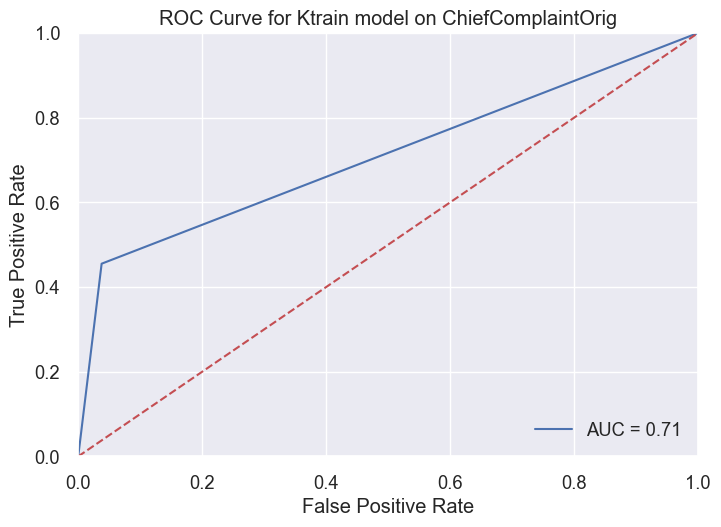

In [75]:
# Plot the curve
sns.set(font_scale=1.2)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC Curve for Ktrain model on ChiefComplaintOrig')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### ChiefComplaintParsed

In [76]:
%%time
# Run ktrain and save results to a new df
df_ktr_ccp_ner = ae.extract(df_ktr_ccp.ChiefComplaintParsedMOD.values, df_ktr_ccp,
                          [('What are the street names?', 'Loc1'),('What is the retail or store or hotel or shop name?','Loc2'),('Where is the geopolitical?','Loc3'),
                           ('Where is the exact location?','Loc4')])

CPU times: total: 14h 43min 18s
Wall time: 3h 13min 47s


In [77]:
df_ktr_ccp_ner.shape

(6934, 16)

In [83]:
print('Number of Loc1: ', len(df_ktr_ccp_ner['Loc1'].unique()))
print('Number of Loc2: ', len(df_ktr_ccp_ner['Loc2'].unique()))
print('Number of Loc3: ',len(df_ktr_ccp_ner['Loc3'].unique()))
print('Number of Loc4: ', len(df_ktr_ccp_ner['Loc4'].unique()))

Number of Loc1:  383
Number of Loc2:  46
Number of Loc3:  17
Number of Loc4:  521


In [89]:
# Pass df to get lat/lon from Google Maps API for Named Entities
call_google_api_ktrain(df_ktr_ccp_ner)

# Pass df to get the 0/1 prediction for the row
get_prediction(df_ktr_ccp_ner)

# Pass df to set the TP/TN/FP/FN values
pred_eval(df_ktr_ccp_ner)

(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2639836, -115.1670589) GEOMETRIC_CENTER Indian Springs Street
---------------
(36.110132, -115.175128) ROOFTOP 3700
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.171784, -115.146861) ROOFTOP 1
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1257073, -115.2506451) GEOMETRIC_CENTER West Spring Mountain Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.170746, -115.217614) GEOMETRIC_CENTER Pershing Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2471258, -115

(36.1895728, -115.3036584) APPROXIMATE Summerlin
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1590854, -115.2058635) APPROXIMATE Charleston
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1992023, -115.3636922) GEOMETRIC_CENTER West Lake Mead Boulevard
---------------
(36.1773314, -115.1924299) GEOMETRIC_CENTER North Valley View Boulevard & West Bonanza Road
---------------
(36.169471, -115.1432467) ROOFTOP 155
---------------
(36.1585988, -115.2026957) 

(36.1026234, -115.2019354) ROOFTOP 4500
---------------
(36.0971011, -115.285072) GEOMETRIC_CENTER Spanish Hills Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1613923, -115.1224271) GEOMETRIC_CENTER East Fremont Street
---------------
(36.1665723, -115.1658667) ROOFTOP Ste 103
---------------
(36.0987973, -115.1754312) ROOFTOP 3850
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1621447, -115.1524187) ROOFTOP Unit A
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1699671, -115.1448235) ROOFTOP 129
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2054764, -115.2746015) GEOMETRIC_CENTER North Harbor Island Dri

(36.1591689, -115.1173471) GEOMETRIC_CENTER East Fremont Street
---------------
(36.1329379, -115.084697) ROOFTOP 4111
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.160565, -115.170576) ROOFTOP # 207
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.17089259999999, -115.1406007) ROOFTOP 217
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1733938, -115.0661438) GEOMETRIC_CENTER East Bonanza
---------------
(36.0988118, -115.1703887) ROOFTOP 3801
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.2141116, -115.3424046) GEOMETRIC_CENTER Desert Hope Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.160725, -115.244152) ROOFTOP 945
---------------
(36.1305455, -115.1382424) ROOFTOP 3247
---------------
(36.1642095, -115.1497702) GEOMETRIC_CENTER South 1st Street
---------------
(36.1166377, -115.1703905) ROOFTOP 3555
---------------
(nan,

(nan, nan) APPROXIMATE Las Vegas
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1150147, -115.296929) GEOMETRIC_CENTER South Fort Apache Road & West Flamingo Road
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.276057, -115.3326156) GEOMETRIC_CENTER Evelyn Yard Court
---------------
(36.0685734, -115.1645755) ROOFTOP 6675
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(35.9840501, -115.1467728) GEOMETRIC_CENTER Nevada 146
---------------
(36.1079197, -115.0564212) ROOFTOP 5255
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1771847, -115.175602) GEOMETRIC_CENTER West Bonanza Road & Rancho Drive
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1366568, -115.1628538) ROOFTOP 2880
---------------
(nan, nan) APPROXIMATE Las Vegas
---------------
(36.1301642, -115.083731) GEOMETRIC_CENTER East Desert Inn Road & Boulder Highway
---------------
(36.102132, -115.1744225) ROOFTOP 3790
---------

In [90]:
# Export results to csv
df_ktr_ccp_ner.to_csv('temp/ktr_ccp.csv')

#### Results

In [91]:
# Pass df, model, and column name to get the get_scores function for evaluating Accuracy, Precision, Recall, and F1
results_ktr_ccp = get_scores(df_ktr_ccp_ner, 'Ktrain', 'ChiefComplaintParsed')

# Save results to a df
results_ktr_df_ccp = pd.DataFrame(results_ktr_ccp, columns = ['Model', 'Field','Accuracy', 'Precision', 'Recall', 'F1'])
results_ktr_df_ccp

,Model,Field,Accuracy,Precision,Recall,F1
0,Ktrain,ChiefComplaintParsed,0.9383,0.4536,0.4213,0.4369


Area Under the Curve - ChiefComplaintParsed

In [92]:
# Get the true positive, true negative, false positive, and false negative numbers to use for calculating auc
preds = df_ktr_ccp_ner['pred_eval'].value_counts()
tp = preds.loc['TP']
tn = preds.loc['TN']
fp = preds.loc['FP']
fn = preds.loc['FN']

In [93]:
# Calculate true positve rate
preds = df_ktr_ccp_ner['pred_eval'].value_counts()
preds

TN    6340
FN     228
FP     200
TP     166
Name: pred_eval, dtype: int64

In [94]:
# Create a list for tpr
tpr = tp /(tp+fn)
tpr

0.4213197969543147

In [95]:
# Create a list for fpr
fpr=fp/(fp+tn)
fpr

0.03058103975535168

In [96]:
#create a list for tpr and fpr
tpr = [0.        ,0.4213197969543147, 1.        ]
fpr = [0.        ,0.03058103975535168, 1.        ]

In [97]:
# Get the roc curve
roc_auc = metrics.auc(fpr, tpr)

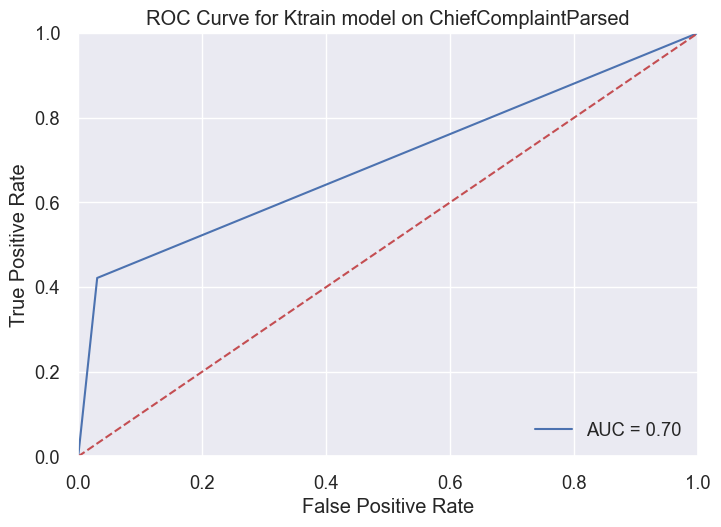

In [98]:
sns.set(font_scale=1.2)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC Curve for Ktrain model on ChiefComplaintParsed')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model Interpretation
After running four models on both “Chief Complaint” fields, the Ktrain model had much better F1-score for the 'ChiefComplaintParsed' and 'ChiefComplaintOrig'. It performed only very slightly better on the “ChiefComplaintParsed” field. This may be because most acronyms are spelled out in that field. Below are the performance metrics for each model sorted from highest F1-score to lowest.

In [158]:
# Combine all the results and sort by F1-Score
results_df = pd.concat([results_sp_df, results_gzt_df, results_crf_df, results_sp_df_ccp, results_gzt_ccp, results_ktr_df, results_ktr_df_ccp,results_crf_ccp_df])
results_df = results_df.sort_values(by=['F1'], ascending = [False])
results_df

,Model,Field,Accuracy,Precision,Recall,F1
0,Ktrain,ChiefComplaintParsed,0.9383,0.4536,0.4213,0.4369
0,Ktrain,ChiefComplaintOrig,0.9338,0.4175,0.4550,0.4354
0,Custom NER w/ CRF,ChiefComplaintOrig,0.8996,0.1962,0.2732,0.2284
0,spaCy w/ Gazetteer,ChiefComplaintParsed,0.8268,0.1305,0.5424,0.2104
0,Custom NER w/ CRF,ChiefComplaintParsed,0.9129,0.2200,0.1887,0.2032
0,spaCy,ChiefComplaintOrig,0.8556,0.1302,0.3305,0.1868
0,spaCy w/ Gazetteer,ChiefComplaintOrig,0.8543,0.1267,0.3285,0.1829
0,spaCy,ChiefComplaintParsed,0.9027,0.1514,0.1422,0.1467


The Ktrain model produces similar precision and recall scores with an F1-score of 0.4369. This means that false positives and false negatives are similar in value and around 44% of the time the correct location was identified when a location was present. The high accuracy of 0.9383 can be attributed to the volume of records in the dataset that do not have a location. The model detected that no location is present most of the time.

Custom NER with CRF on 'ChiefComplaintOrig' field performed best after the Ktrain model with F1-score of 0.2284 following closely by spaCy with the street name Gazetteer on 'ChiefComplaintParsed' field with F1-score of 0.2104 but they were both much lower than Ktrain models. spaCy with the street name Gazetteer on the 'ChiefComplaintParsed' field had the highest recall with 0.5424, but it had a low Precision with 0.1305 due to the overidentification of streets.